# Lab 3: Support vector machine
## 1. Quadratic programming and QP-solver

### Task:
#### 1. Install QP-solver, understand it's interface http://cvxopt.org/userguide/coneprog.html#quadratic-programming

In [1]:
!pip install --upgrade cvxopt
from cvxopt import solvers
#?solvers.qp

Requirement already up-to-date: cvxopt in c:\anaconda\lib\site-packages


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import solvers
#?solvers.qp
%matplotlib inline

C:\Anaconda\lib\site-packages\matplotlib\contour.py:920: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


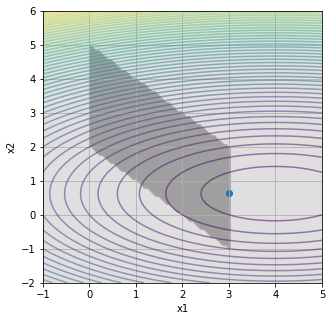

In [3]:
x1 = np.linspace(-1, 5, 100)
x2 = np.linspace(-2, 6, 100)
xx1, xx2 = np.meshgrid(x1, x2)

f = -8*xx1 - 5*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 2-xx1)

plt.figure(figsize=(5, 5))
plt.grid(True)
plt.xlabel('x1')
plt.ylabel('x2')

plt.contour(x1, x2, f, 50, alpha=0.5)
plt.contourf(x1, x2, np.invert(constr1 & constr2 & constr3), 1, alpha=0.5, linewidths=4, cmap='gray')
_ = plt.scatter([3], [0.65])

#### 2.Test solver with that problem:
$$f(\boldsymbol x) = -8x_1 - 5x_2 + x_1^2 + 4x_2^2, 
\\\quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_1 + x_2 \geq 2$$

In [4]:
from cvxopt import matrix
from numpy import array

P=2*matrix([[1.,0.],[0.,4.]]) # n x n dense matix (1/2 -> 2)
q=matrix([-8.,-5.])           # n x 1 dense matrix
G=matrix([[1.,1.],[-1., 0.],[1.,0.],[-1.,-1.]]).trans()  # m x n dense matrix #.trans()
h=matrix([5., 0., 3., -2. ]) #m x 1 dense
sol=solvers.qp(P, q, G, h)
print (sol['status'])
print(sol['x'])
print('')
print(sol['z'])

     pcost       dcost       gap    pres   dres
 0: -1.6087e+01 -2.6485e+01  1e+01  3e-17  2e-16
 1: -1.6449e+01 -1.6944e+01  5e-01  9e-17  2e-16
 2: -1.6561e+01 -1.6569e+01  8e-03  2e-16  1e-16
 3: -1.6562e+01 -1.6563e+01  8e-05  2e-16  9e-17
 4: -1.6562e+01 -1.6563e+01  8e-07  1e-16  5e-17
Optimal solution found.
optimal
[ 3.00e+00]
[ 6.25e-01]


[ 3.32e-07]
[ 4.59e-08]
[ 2.00e+00]
[ 4.00e-08]



#### 3.Which inequality constraints are not active, that means they do not influence optimal point. Can you delete some constraints without changing optimal point?

In [5]:
#solving the inequalities and testing there are three not active conditions. deeting its make no sense on result

G1=matrix([[1.,0.]]).trans()  # m x n dense matrix #.trans()
h1=matrix([ 3. ]) #m x 1 dense

sol1=solvers.qp(P, q, G1, h1)
print (sol1['x'])
print('')
print(sol1['z'])

     pcost       dcost       gap    pres   dres
 0: -1.7451e+01 -1.7007e+01  7e-01  6e-01  1e-16
 1: -1.7202e+01 -1.6722e+01  1e-02  1e-01  7e-17
 2: -1.6554e+01 -1.6563e+01  8e-03  0e+00  2e-16
 3: -1.6562e+01 -1.6563e+01  8e-05  1e-16  0e+00
 4: -1.6562e+01 -1.6563e+01  8e-07  0e+00  5e-17
Optimal solution found.
[ 3.00e+00]
[ 6.25e-01]


[ 2.00e+00]



## 2. Linear SVM

### Task

### 1. Reduce SVM optimisation problem to QP, and implement Linear SVM using QP-solver

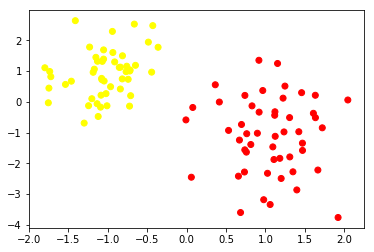

In [6]:
from sklearn.datasets import make_classification
random_state = 8

X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=random_state)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

In [7]:
#replace 0 to -1
y[y==0]=-1
print (y)

[ 1 -1  1 -1 -1  1 -1 -1  1  1  1 -1  1 -1  1 -1 -1  1  1 -1  1  1 -1  1  1
 -1 -1 -1 -1 -1 -1  1  1  1  1  1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1 -1
  1  1 -1  1  1  1 -1 -1  1 -1 -1  1  1  1  1 -1  1 -1  1 -1 -1 -1 -1  1  1
 -1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1  1  1  1  1  1 -1  1 -1]


After solving QP optimization problem $(\boldsymbol w^*, \boldsymbol \xi^*, b^*)$, some of the constraints becomes _active_ (become equations):
$$\quad y_n (\boldsymbol w^{*T} \boldsymbol x_n + b^*) = 1 - \xi^*_{n}$$
Objects that correspond to these equations are called **support vectors**


In [8]:
from cvxopt import matrix, spmatrix, sparse
solvers.options['show_progress']=False

from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Train function
        """
        N=X.shape[0] #100
        d=X.shape[1] #2
        dim=N+d+1
       
        P=spmatrix(0.5,[0,1],[0,1],(dim,dim))    # n x n 
        
        q=np.full(dim,self.C)
        for i in range(0,3):
            q[i]=0
        q=matrix(q)
                   
        G=np.zeros((2*N,dim))
        for j in range(0,d):
         for i in range(0,N):
            G[i,j]=-y[i]*X[i,j]
        for i in range(N):
            G[i,d+1+i]=-1
            G[N+i,d+1+i]=-1 
            G[i,d]=-y[i]
        G=matrix(G)        
        
        h=np.zeros((2*N,1))
        for i in range(0,N):
            h[i]=-1
        h=matrix(h)
         
        sol=solvers.qp(P, q, G, h)
        
        list=[]
        self.weights_ =sol['x'][0:2]
        self.bias_ = sol['x'][2] #d=2
        self.ksi_ = sol['x'][d+1:]
         
        for i in range(N):
            if abs(y[i]*(np.dot(np.array(self.weights_).transpose(),X[i,:])+self.bias_)-1+self.ksi_[i])<=0.000001:
                list.append(i)
                #self.sv_=np.insert(self.sv_,0,int(i),axis=0) #number of support vector  
        self.sv_=list
        return {'weights': self.weights_, 'bias': self.bias_, 'ksi': self.ksi_,'sv':self.sv_}      
        
    def predict_proba(self, X):
        return (np.dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return np.sign(self.predict_proba(X))

### 2.Generate different 2D sample for binary classification task:
* linearly separable
* with separable classes, but not linearly
* not-separable classes in that feature space

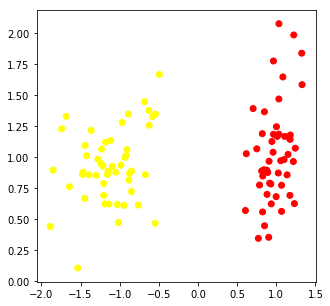

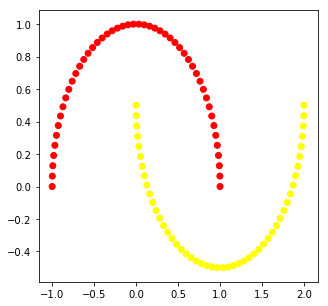

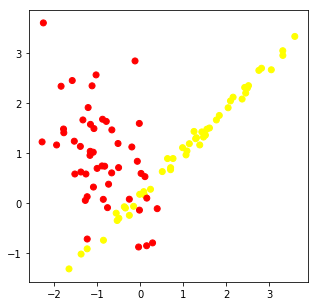

In [9]:
# sample1 = linearly separable
plt.figure(figsize=(5, 5))
random_state = 1
s1={}
s1['X'], s1['y'] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=random_state)
plt.scatter(s1['X'][:, 0], s1['X'][:, 1], c=s1['y'],cmap='autumn')

s1['y'][s1['y']==0]=-1

# sample2 = not linearly but separable 
plt.figure(figsize=(5, 5))
from sklearn.datasets import make_moons
s2={}
s2['X'], s2['y'] =make_moons(n_samples=100, shuffle=True, noise=None, random_state=random_state)
plt.scatter(s2['X'][:, 0], s2['X'][:, 1], c=s2['y'],cmap='autumn')
s2['y'][s2['y']==0]=-1

# sample3 not-separable 
plt.figure(figsize=(5, 5))
random_state = 9
s3={}
s3['X'], s3['y'] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=random_state)
plt.scatter(s3['X'][:, 0], s3['X'][:, 1], c=s3['y'],cmap='autumn')
s3['y'][s3['y']==0]=-1

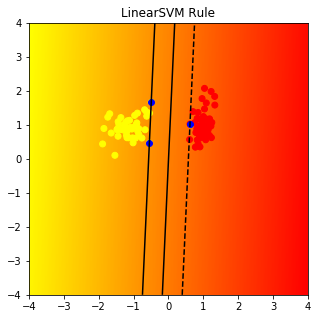

In [10]:
model = LinearSVM(C=1.)
X=s1['X']
y=s1['y']
y[y==0]=-1
H=model.fit(X, y)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
plt.scatter(X[model.sv_, 0], X[model.sv_, 1], color='blue')


xvals = np.linspace(-4, 4, 200)
yvals = np.linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)

# Decision rule color encoding
plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Level lines of 0.5
plt.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)

plt.xlim([-4, 4])
plt.ylim([-4, 4])
_ = plt.title('LinearSVM Rule')

### 3.Test linear SVM on these samples. Draw plots with separating hyperplane, and with level lines, which constraint "street"  $f(\boldsymbol x) = \pm 1$. Use different point shape or size for **support vectors**. Build classifier with different $C$


In [11]:
def plot(model, samples):
    plt.figure(figsize=(5, 5))
    plt.scatter(samples['X'][:, 0], samples['X'][:, 1], c=samples['y'], cmap='autumn')
    plt.scatter(samples['X'][model.sv_, 0], samples['X'][model.sv_, 1], color='blue')

    xvals = np.linspace(-4, 4, 200)
    yvals = np.linspace(-4, 4, 200)
    

    #print proba
    xx, yy = np.meshgrid(xvals, yvals)
    zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)

    # Decision rule color encoding
    plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

    # Level lines 
    plt.contour(xx, yy, zz, levels=(-1,0,1,), colors='k', linewidths=1.5, zorder=1)
    
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    _ = plt.title('')   

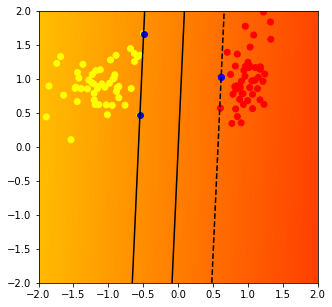

In [12]:
#linearly separable
model=LinearSVM(C=1.)
fitting = model.fit(s1['X'], s1['y'])
plot(model, s1)

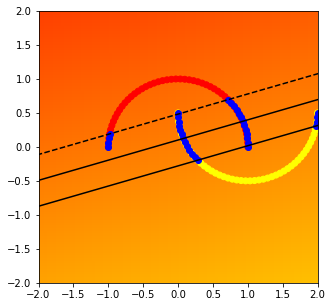

In [13]:
model=LinearSVM(C=1.)
fitting = model.fit(s2['X'], s2['y'])
plot(model, s2)

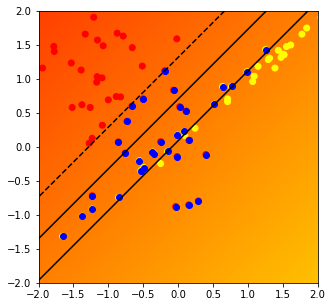

In [14]:
model=LinearSVM(C=1.)
fitting = model.fit(s3['X'], s3['y'])
plot(model, s3)

#### 4 Build classifier with different  C. How the number of support vectors depends on parameter  C?

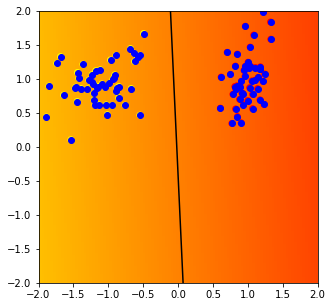

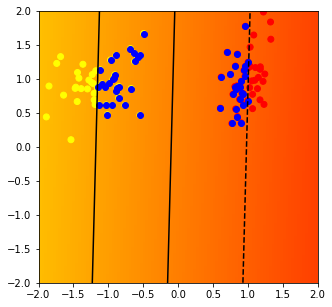

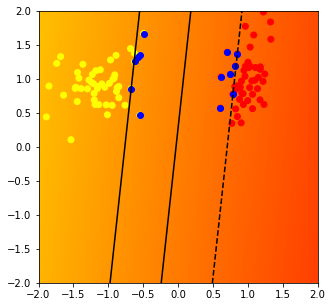

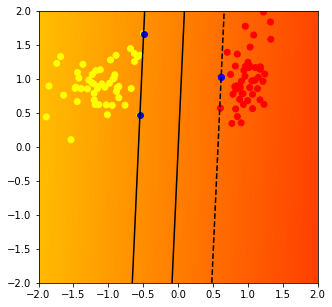

In [15]:
model=LinearSVM(C=0.001)
fitting = model.fit(s1['X'], s1['y'])
plot(model, s1)

model=LinearSVM(C=0.01)
fitting = model.fit(s1['X'], s1['y'])
plot(model, s1)

model=LinearSVM(C=0.1)
fitting = model.fit(s1['X'], s1['y'])
plot(model, s1)

model=LinearSVM(C=1.)
fitting = model.fit(s1['X'], s1['y'])
plot(model, s1)

the bigger is a Hyperparameter  C  the less number of support vectors

#### 5 Using explicit feature transformation train linear SVM to separate non-leary separable classes with a quadratic hyperplane. Show it on the plot.

In [16]:
from cvxopt import matrix, spmatrix, sparse
solvers.options['show_progress']=False

from sklearn.base import BaseEstimator

class LinearSVM_5(BaseEstimator):
    def __init__(self, C):
        self.C = C
       
    def fit(self, X, y):
        """
        Train function
        """
        N=X.shape[0] #100
        d=X.shape[1] #2
        dim=N+d+1
       
        P=spmatrix(0.5,[0,1],[0,1],(dim,dim))    # n x n 
        
        q=np.full(dim,self.C)
        for i in range(0,3):
            q[i]=0
        q=matrix(q)
                   
        G=np.zeros((2*N,dim))
        for j in range(0,d):
         for i in range(0,N):
            G[i,j]=-y[i]*X[i,j]
        for i in range(N):
            G[i,d+1+i]=-1
            G[N+i,d+1+i]=-1 
            G[i,d]=-y[i]
        G=matrix(G)        
        
        h=np.zeros((2*N,1))
        for i in range(0,N):
            h[i]=-1
        h=matrix(h)
         
        sol=solvers.qp(P, q, G, h)
        
        list=[]
        self.weights_ =sol['x'][0:d]
        self.bias_ = sol['x'][5] #d=5
        self.ksi_ = sol['x'][d+1:]
         
        for i in range(N):
            if abs(y[i]*(np.dot(np.array(self.weights_).transpose(),X[i,:])+self.bias_)-1+self.ksi_[i])<=0.000001:
                list.append(i)
                #self.sv_=np.insert(self.sv_,0,int(i),axis=0) #number of support vector  
        self.sv_=list
        return {'weights': self.weights_, 'bias': self.bias_, 'ksi': self.ksi_,'sv':self.sv_}      
        
    def predict_proba(self, X):
        return (np.dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return np.sign(self.predict_proba(X))

In [17]:
s4=s2['X']
s4 = np.insert(s4, 0 ,[s2['X'][:, 0] * s2['X'][:, 0],   s2['X'][:, 0] * s2['X'][:, 1],   s2['X'][:, 1] * s2['X'][:, 1]],axis=1)

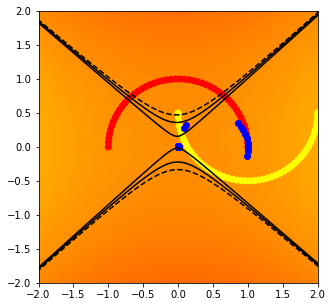

In [18]:
    model = LinearSVM_5(C=1.)
    fitting = model.fit(s4, s2['y'])

    plt.figure(figsize=(5, 5))
    plt.scatter(s4[:, 3], s4[:, 4], c=s2['y'], cmap='autumn')
    plt.scatter(s4[model.sv_, 0], s4[model.sv_, 1], color='blue')

    xvals = np.linspace(-4, 4, 200)
    yvals = np.linspace(-4, 4, 200)

    #print proba
    xx, yy = np.meshgrid(xvals, yvals)
    zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel(),(xx*xx).ravel(),(xx*yy).ravel(),(yy*yy).ravel()]), xx.shape)
    # Decision rule color encoding
    plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
    # Level lines 
    plt.contour(xx, yy, zz, levels=(-1,0,1,), colors='k', linewidths=1.5, zorder=1)
    
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    _ = plt.title('')
    

## 3. Dual problem and Kernel SVM


1. Implement kernel SVM, using QP-solver


In [49]:
from sklearn.base import BaseEstimator
class LinearSVM_2(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
    
        kernel={}
        kernel['lin']=lambda x,y1,p: np.dot(x,y1)
        kernel['pow']=lambda x,y1,p: np.power((np.dot(x,y1)+1),self.param)
        kernel['RBF']=lambda x,y1,p: np.exp((-1*np.power((np.linalg.norm(x-y1)),2)/(2*self.param)))
        self.kernel=kernel
        #self.param=param
        
    def fit(self, X, y, kernel, param=1):
        N=X.shape[0]
        d=X.shape[1]
        dim = N+d+1
        self.weights_ = np.empty(d)
        self.X=X
        self.N=N
        self.y=y
        self.ker=kernel#
        self.param=param
        
        P = spmatrix(1.0, range(d), range(d),(N,N))
        for i in range(N):
            for j in range(N):
                P[i,j]=y[i]*y[j]*self.kernel[kernel](X[i,:],X[j,:],param)        
               
        q=np.full(N,-1.)
        q=matrix(q)
        
        G = spmatrix(1.,range(N),range(N),(2*N, N))+spmatrix(-1.,range(N,2*N),range(N),(2*N, N))
        
        h=np.zeros((2*N,1))
        for i in range(0,N):
            h[i]=self.C
        h=matrix(h)
        
        b=matrix(0.)
        A=matrix(y.astype('d'),(1,N))
        
        
        sol=solvers.qp(P,q,G,h,A,b)
        self.alp=sol['x']
        
        for i in range(d):
            self.weights_[i] = np.sum(self.alp*y*X[:,i])
        p=0.

        xi_=sol['x'][d:len(sol['x'])-1]
        array=np.empty([0, d])
        ysup=np.empty([0, 1])
        for i in range(N):
            if self.alp[i]>0.0000001:
                array=np.insert(array, 0,X[i,:], axis=0)
                ysup=np.insert(ysup, 0,y[i], axis=0)
        i=2
        for j in range(N):
             p+=ysup[i]*-self.alp[i]*ysup[i]*self.kernel[kernel](X[j,:],X[i,:],self.param)
        
        self.bias_ =p
        return {'weights': self.weights_, 'bias': self.bias_,'sup': array}
            
    def predict_proba(self, X):         
        ans=np.empty([0, 1])
        for x in X:  
         summ=0.
         for i in range(self.N):
             summ+=  self.alp[i]*self.y[i]*self.kernel[self.ker](x,self.X[i,:],self.param)
         ans=np.insert(ans,0,summ,axis=0)
        return (ans + self.bias_).flatten()
            
    def predict(self, X):
        return np.sign(self.predict_proba(X))

2. Test linear SVM on these samples. Draw plots with separating hyperplane, and with level lines, which constraint "street" $f(\boldsymbol x) = \pm 1$. Use different point shape or size for **support vectors**. Test different kernels:
    - linear: $k(x, x') = x^Tx'$
    - polynomial:$k(x, x') = (x^Tx' + 1)^d$ of different power $d = 2,3,\dots$
    - gauss-RBG: $k(x, x') = \exp(-\frac{1}{2\sigma}\|x - x'\|^2)$



In [50]:
def plotresK(X, y,  typ, C,kernel, param=1):
     svm = LinearSVM_2(C=C)
     plt.figure(figsize=(5, 5))
     plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
     tr = svm.fit(X, y,kernel,param)
     xvals = np.linspace(-4, 4, 50)
     yvals = np.linspace(-4, 4, 50)

     xx, yy = np.meshgrid(xvals, yvals)
     zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)

     # Decision rule color encoding
     plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

     # Level lines of 0.5
     plt.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)

     plt.xlim([-4, 4])
     plt.ylim([-4, 4])
     plt.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
     if kernel == 'lin':
        s=', linear kernel'
     elif kernel == 'pow':
        s=', polynomial kernel'
     elif kernel == 'RBF':
        s=', RBF'
     plt.title(typ+s+', C=%0.2f'%C)

     plt.show()  
     print "Number of support vectors:", len(tr['sup'][:,1])
     return 

3.Describe SVM with polynomial kernel behavior when you vary parameters $C$ and kernel degree $d$.

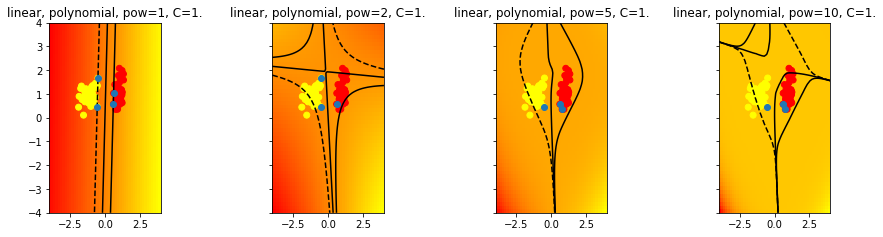

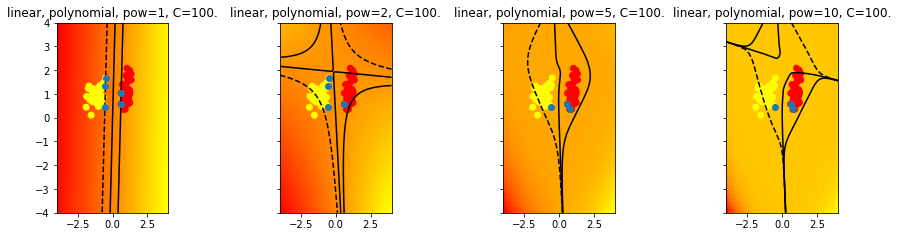

In [66]:
svm = LinearSVM_2(C=1.)
xvals = np.linspace(-4, 4, 50)
yvals = np.linspace(-4, 4, 50)
xx, yy = np.meshgrid(xvals, yvals)


f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharex='col',sharey='row',  figsize=(14,3.5))

plt.xlim([-4, 4])
plt.ylim([-4, 4])


X=s1['X']
y=s1['y']

tr = svm.fit(X, y,'pow',1)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax1.set_title('linear, polynomial, pow=1, C=1.')
ax1.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax1.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')

ax1.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'pow',2)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax2.set_title('linear, polynomial, pow=2, C=1.')
ax2.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax2.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax2.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'pow',5)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax3.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax3.set_title('linear, polynomial, pow=5, C=1.')
ax3.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax3.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax3.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'pow',10)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax4.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax4.set_title('linear, polynomial, pow=10, C=1.')
ax4.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax4.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax4.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

f.subplots_adjust(hspace=0.3,wspace=1.)
#plt.show()
#--------------------------------------------------------------------

svm = LinearSVM_2(C=100.)
xvals = np.linspace(-4, 4, 50)
yvals = np.linspace(-4, 4, 50)
xx, yy = np.meshgrid(xvals, yvals)


f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharex='col',sharey='row',  figsize=(14,3.5))

plt.xlim([-4, 4])
plt.ylim([-4, 4])


X=s1['X']
y=s1['y']

tr = svm.fit(X, y,'pow',1)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax1.set_title('linear, polynomial, pow=1, C=100.')
ax1.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax1.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')

ax1.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'pow',2)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax2.set_title('linear, polynomial, pow=2, C=100.')
ax2.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax2.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax2.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'pow',5)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax3.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax3.set_title('linear, polynomial, pow=5, C=100.')
ax3.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax3.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax3.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'pow',10)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax4.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax4.set_title('linear, polynomial, pow=10, C=100.')
ax4.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax4.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax4.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

f.subplots_adjust(hspace=0.3,wspace=1.)
plt.show()

for linear separable sample there is no significant difference  if we change C (the difference in quantity of supvec is only one vector, and this dependense escapes if we take large values of power)

testing others pairs of C and d, analizing different sets, it can be seen that we need to find optimal set of parameters.

4.Descrive SVM with RBF kernel behavior when you vary $C$ and $\sigma$. Vary parameters at logarithmic scale. Which parameters lead to overfitting, which parameters give low quality model.

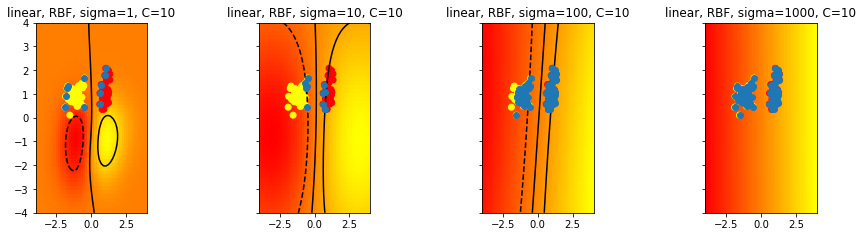

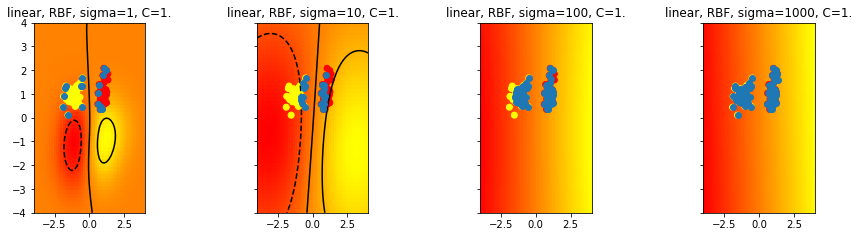

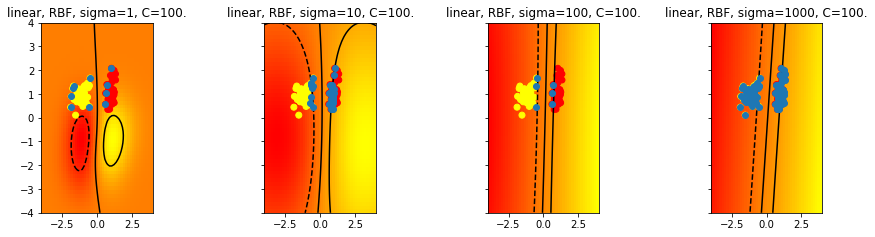

In [69]:

svm = LinearSVM_2(C=10.)
xvals = np.linspace(-4, 4, 50)
yvals = np.linspace(-4, 4, 50)
xx, yy = np.meshgrid(xvals, yvals)


f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharex='col',sharey='row',  figsize=(14,3.5))

plt.xlim([-4, 4])
plt.ylim([-4, 4])


X=s1['X']
y=s1['y']

tr = svm.fit(X, y,'RBF',1)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax1.set_title('linear, RBF, sigma=1, C=10')
ax1.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax1.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')

ax1.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'RBF',10)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax2.set_title('linear, RBF, sigma=10, C=10')
ax2.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax2.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax2.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'RBF',100)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax3.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax3.set_title('linear, RBF, sigma=100, C=10')
ax3.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax3.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax3.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'RBF',1000)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax4.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax4.set_title('linear, RBF, sigma=1000, C=10')
ax4.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax4.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax4.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

f.subplots_adjust(hspace=0.3,wspace=1.)

#--------------------------------------
svm = LinearSVM_2(C=1.)
xvals = np.linspace(-4, 4, 50)
yvals = np.linspace(-4, 4, 50)
xx, yy = np.meshgrid(xvals, yvals)


f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharex='col',sharey='row',  figsize=(14,3.5))

plt.xlim([-4, 4])
plt.ylim([-4, 4])


X=s1['X']
y=s1['y']

tr = svm.fit(X, y,'RBF',1)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax1.set_title('linear, RBF, sigma=1, C=1.')
ax1.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax1.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')

ax1.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'RBF',10)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax2.set_title('linear, RBF, sigma=10, C=1.')
ax2.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax2.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax2.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'RBF',100)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax3.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax3.set_title('linear, RBF, sigma=100, C=1.')
ax3.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax3.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax3.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'RBF',1000)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax4.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax4.set_title('linear, RBF, sigma=1000, C=1.')
ax4.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax4.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax4.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

f.subplots_adjust(hspace=0.3,wspace=1.)
#plt.show()
#--------------------------------------------------------------------

svm = LinearSVM_2(C=100.)
xvals = np.linspace(-4, 4, 50)
yvals = np.linspace(-4, 4, 50)
xx, yy = np.meshgrid(xvals, yvals)


f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharex='col',sharey='row',  figsize=(14,3.5))

plt.xlim([-4, 4])
plt.ylim([-4, 4])


X=s1['X']
y=s1['y']

tr = svm.fit(X, y,'RBF',1)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax1.set_title('linear, RBF, sigma=1, C=100.')
ax1.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax1.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')

ax1.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'RBF',10)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax2.set_title('linear, RBF, sigma=10, C=100.')
ax2.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax2.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax2.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'RBF',100)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax3.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax3.set_title('linear, RBF, sigma=100, C=100.')
ax3.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax3.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax3.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'RBF',1000)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax4.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax4.set_title('linear, RBF, sigma=1000, C=100.')
ax4.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax4.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax4.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

f.subplots_adjust(hspace=0.3,wspace=1.)
plt.show()

This table clearly shows that in such problems it is neccessary to find optimal pair of parameters. 

if parameters C and sigma are equal then there is the optimal situation: number of supvec is minimal.

if C<sigma or C>sigma then, depending on difference between given values, the situation is worse: number of supvec increases.

 #### Which parameters lead to overfitting, which parameters give low quality model.

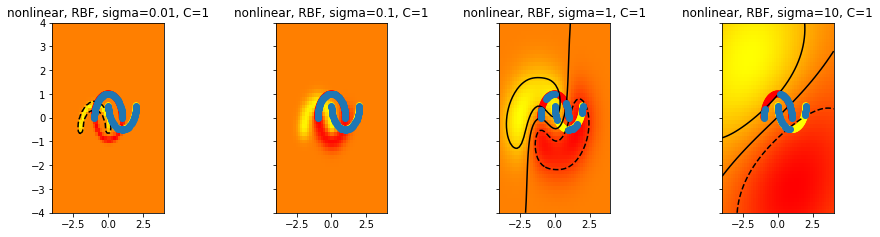

In [73]:
svm = LinearSVM_2(C=1.)
xvals = np.linspace(-4, 4, 50)
yvals = np.linspace(-4, 4, 50)
xx, yy = np.meshgrid(xvals, yvals)


f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharex='col',sharey='row',  figsize=(14,3.5))

plt.xlim([-4, 4])
plt.ylim([-4, 4])


X=s2['X']
y=s2['y']

tr = svm.fit(X, y,'RBF',0.01)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax1.set_title('nonlinear, RBF, sigma=0.01, C=1')
ax1.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax1.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')

ax1.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'RBF',0.10)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax2.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax2.set_title('nonlinear, RBF, sigma=0.1, C=1')
ax2.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax2.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax2.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'RBF',1)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax3.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax3.set_title('nonlinear, RBF, sigma=1, C=1')
ax3.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax3.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax3.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)


tr = svm.fit(X, y,'RBF',10)
zz = np.reshape(svm.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
ax4.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')
ax4.set_title('nonlinear, RBF, sigma=10, C=1')
ax4.contour(xx, yy, zz, levels=(-1,0,1), colors='k', linewidths=1.5, zorder=1)
ax4.scatter(tr['sup'][:,0],tr['sup'][:,1],cmap='winter')
ax4.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

f.subplots_adjust(hspace=0.3,wspace=1.)
plt.show()

overfitting becomes when there are small values of parameter sigma. our conclusion about optimal pair of parameters is tested and prooved also on nonlinear sample.

moreover, large values of sigma gives lower quality of the model.